### 1. การติดตั้งและ Import Library

- ส่วนนี้คือการติดตั้ง library ที่จำเป็น เช่น unsloth, transformers, trl
- transformers คือ library หลักของ HuggingFace ที่มีโมเดล NLP และ Vision ที่ pretrained มาแล้ว
- trl เอาไว้ train/fine-tune โมเดลโดยใช้เทคนิค reinforcement learning หรือ supervised fine-tuning

In [ ]:
# # 1) สร้างและเข้า env
# python -m venv .venv
# # Windows: .\.venv\Scripts\Activate.ps1
# # Linux/macOS: source .venv/bin/activate
# python -m pip install -U pip

# # 2) ล้างของเก่า
# pip uninstall -y torch torchvision torchaudio xformers

# # 3) ติดตั้ง PyTorch + CUDA runtime (เลือก 1 ทาง)
# pip install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio
# # หรือใช้คำสั่งที่หน้า Get Started ให้มาสำหรับเวอร์ชัน CUDA ล่าสุดของคุณ

# # 4) xformers (เลือกจากล้อที่เข้ากัน)
# pip install xformers -f https://download.pytorch.org/whl/xformers/

# # 5) Unsloth
# pip install unsloth

ตรวจสอบว่า PyTorch เห็น GPU:

In [2]:
import torch, platform

print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.10.18
Torch: 2.8.0+cu129
Built with CUDA: 12.9
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


### 2. โหลดโมเดล Vision-Language

- โหลดโมเดล Qwen2.5-VL (Vision-Language model) ที่สามารถเข้าใจ รูปภาพ + ข้อความ
- tokenizer ทำหน้าที่แปลงข้อความเป็นตัวเลข (tokens)
- load_in_4bit=True → ใช้ quantization 4-bit เพื่อลดขนาดโมเดลและประหยัด GPU memory

In [1]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1005 17:06:45.353000 13448 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


### 3. เพิ่ม LoRA (Low-Rank Adaptation)

- ใช้ LoRA (Low-Rank Adaptation) เพื่อ fine-tune โมเดลเฉพาะบางพารามิเตอร์ แทนที่จะ train ใหม่ทั้งหมด
- เราสามารถเลือกว่าจะฝึกเฉพาะ vision part หรือ language part ของโมเดลได้

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

### 4. โหลด Dataset

#### Test: (ภาพสมการ LaTeX)

โหลด dataset ของภาพที่มีสมการคณิตศาสตร์ (handwritten formula) + คำตอบเป็น LaTeX text

In [4]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

Generating test split: 100%|██████████| 7632/7632 [00:00<00:00, 122788.37 examples/s]


In [5]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

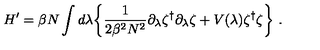

In [6]:
dataset[2]["image"]

ตรวจชนิดตัวแปรตรง ๆ

In [11]:
img = dataset[2]["image"]
print(type(img))                 # ดูชนิดอ็อบเจ็กต์
print(img.__class__.__name__)    # ดูชื่อคลาสแบบสั้น

<class 'PIL.PngImagePlugin.PngImageFile'>
PngImageFile


เช็คว่าเป็น PIL จริงหรือไม่

In [12]:
from PIL import Image
print(isinstance(img, Image.Image))  # True ถ้าเป็นภาพจาก PIL

True


ดู schema ของ dataset (ยืนยัน feature)

In [13]:
print(dataset.features)                   # โครงสร้างฟีเจอร์
print(type(dataset.features["image"]))    # มักเป็น datasets.features.image.Image

{'image': Image(mode=None, decode=True), 'text': Value('string')}
<class 'datasets.features.image.Image'>


ดูคุณสมบัติภาพ (size/format/mode)

In [14]:
print("size:", img.size)     # (width, height)
print("mode:", img.mode)     # เช่น 'RGB', 'L'
print("format:", img.format) # เช่น 'PNG', 'JPEG'

size: (320, 50)
mode: RGB
format: PNG


In [8]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

In [7]:
from IPython.display import display, Math, Latex
latex = dataset[2]["text"]
display(Math(latex))

<IPython.core.display.Math object>

#### Main : ประกอบร่าง dataset ของเราเอง

In [18]:
import kagglehub

path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")

print("Path to dataset files:", path)

100%|██████████| 182M/182M [00:23<00:00, 7.99MB/s] 

Extracting files...


Path to dataset files: C:\Users\namth\.cache\kagglehub\datasets\fernando2rad\x-ray-lung-diseases-images-9-classes\versions\1


จับคู่จาก CSV + โฟลเดอร์ภาพ → ได้ image & text ตาม CSV

In [5]:
from pathlib import Path
import pandas as pd
from datasets import Dataset, Image as HFImage

# --- พาธหลัก ---
images_root = Path("X-ray Lung Diseases Images (9 classes)")
csv_dir     = Path("prepare_data/disease_output/csv")

# --- 8 คลาสปลายทาง ---
ALLOWED_CLASSES = {
    "Chest_Changes",
    "Degenerative_Infectious",
    "Higher_Density",
    "Inflammatory_Pneumonia",
    "Lower_Density",
    "Mediastinal_Changes",
    "Normal",
    "Obstructive",
}

valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# --- นโยบายเมื่อจำนวน text != จำนวนรูป ---
#   "TRUNCATE": ตัดทิ้งข้อความส่วนเกิน/ส่วนเกินของอะไรก็ตามให้พอดีกับจำนวนรูป (ยึดรูปเป็นหลัก)
#   "CYCLE": เติม/ทำซ้ำข้อความแบบวนลูปให้เท่าจำนวนรูป
#   "PAD_CLASS": เติมด้วยชื่อคลาส
MISMATCH_POLICY = "TRUNCATE"  # <- แก้ได้ตามต้องการ

def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def align_texts_to_images(text_series: pd.Series, n_images: int, cls_name: str) -> pd.Series:
    """ปรับความยาวข้อความให้เท่ากับจำนวนรูป ตามนโยบาย MISMATCH_POLICY"""
    s = text_series.fillna("").astype(str).reset_index(drop=True)
    n_text = len(s)

    if n_text == n_images:
        return s

    if MISMATCH_POLICY == "TRUNCATE":
        # ยึดจำนวนรูปเป็นหลัก: ตัดให้พอดีจำนวนรูป
        if n_text >= n_images:
            return s.iloc[:n_images].reset_index(drop=True)
        else:
            # ข้อความน้อยกว่ารูป → เติมด้วยชื่อคลาสจนเท่ารูป
            pad = pd.Series([cls_name] * (n_images - n_text))
            return pd.concat([s, pad], ignore_index=True)

    elif MISMATCH_POLICY == "CYCLE":
        if n_text == 0:
            return pd.Series([cls_name] * n_images)
        reps = (n_images + n_text - 1) // n_text
        out = pd.concat([s] * reps, ignore_index=True).iloc[:n_images]
        return out.reset_index(drop=True)

    elif MISMATCH_POLICY == "PAD_CLASS":
        if n_text >= n_images:
            return s.iloc[:n_images].reset_index(drop=True)
        else:
            pad = pd.Series([cls_name] * (n_images - n_text))
            return pd.concat([s, pad], ignore_index=True)

    else:
        raise ValueError(f"Unknown MISMATCH_POLICY: {MISMATCH_POLICY}")

# --- อ่านและประกอบข้อมูลจากทุก CSV ---
rows = []
for csv_path in sorted(csv_dir.glob("*.csv")):
    cls = csv_path.stem.strip()
    if cls not in ALLOWED_CLASSES:
        continue

    df = pd.read_csv(csv_path, encoding="utf-8-sig")
    df["__csv_name__"] = cls

    filename_col = pick_col(df.columns, ["filename", "file", "image", "img", "path", "filepath"])
    text_col     = pick_col(df.columns, ["text", "caption", "report", "label_text", "description"])
    class_col    = pick_col(df.columns, ["class", "label", "category", "disease", "folder"])

    # เตรียมไฟล์รูปในโฟลเดอร์นี้ (sort เพื่อให้จับคู่ตามลำดับชื่อไฟล์)
    img_files = sorted(
        [p for p in (images_root / cls).rglob("*") if p.suffix.lower() in valid_exts and p.is_file()],
        key=lambda p: p.name
    )
    n_img = len(img_files)

    if n_img == 0:
        print(f"[WARN] โฟลเดอร์ {cls} ไม่มีรูป ถูกข้าม")
        continue

    # ทำคอลัมน์ข้อความ (ถ้าไม่มี text ให้ใช้ชื่อคลาสเป็นข้อความ)
    if text_col is None:
        df["__text__"] = cls
        n_text = len(df)
    else:
        df["__text__"] = df[text_col].astype(str)
        n_text = len(df)

    # ถ้ามี filename ให้ใช้จับคู่ตรงชื่อไฟล์ + ยึดจำนวนรูปเป็นหลัก
    if filename_col is not None:
        df = df.copy()
        df["__filename__"] = df[filename_col].astype(str).map(lambda x: Path(x).name)
        # ทำดัชนีข้อความโดยชื่อไฟล์
        text_by_name = df.drop_duplicates(subset="__filename__")[["__filename__", "__text__"]].set_index("__filename__")["__text__"]

        # สร้างลิสต์ตามลำดับรูปจริง
        image_names = [p.name for p in img_files]
        # ดึงข้อความตามชื่อไฟล์ ถ้าไม่พบให้ fallback เป็นชื่อคลาส
        aligned_texts = [text_by_name.get(name, cls) for name in image_names]
        aligned_texts = pd.Series(aligned_texts, dtype=str)

        # ไม่ต้องสนใจจำนวนแถวใน CSV ว่ามาก/น้อยกว่า — ยึดจำนวนรูปเป็นหลักแล้วเรียบร้อย
        use_texts = aligned_texts

    else:
        # ไม่มี filename → จับคู่ตามลำดับ และ "ยึดจำนวนรูปเป็นหลัก" ด้วยนโยบายที่ตั้งไว้
        use_texts = align_texts_to_images(df["__text__"], n_img, cls)

        # แจ้งเตือนความต่าง (ช่วย debug)
        if len(df) != n_img:
            print(f"[INFO] {csv_path.name}: ข้อความ {len(df)} รายการ, รูป {n_img} ไฟล์ → จับคู่แบบ {MISMATCH_POLICY} ให้เหลือ/เท่ากับ {n_img}")

    # ประกอบ DataFrame ของคลาสนี้
    out = pd.DataFrame({
        "image_path": [p.as_posix() for p in img_files],
        "text": use_texts,
        "__class__": cls
    })
    rows.append(out)

# รวมทุกคลาส
if not rows:
    raise RuntimeError("ไม่พบข้อมูลหลังประมวลผล — ตรวจโฟลเดอร์/CSV อีกครั้ง")

meta = pd.concat(rows, ignore_index=True)

# กรองเฉพาะไฟล์ที่มีอยู่จริง และลบซ้ำ
meta = meta[meta["image_path"].map(lambda p: p and Path(p).exists())].drop_duplicates().reset_index(drop=True)

# รายงานจำนวนภาพต่อคลาส
print("จำนวนภาพต่อคลาส:", meta["__class__"].value_counts().to_dict())

# สร้าง HF Dataset
hf = Dataset.from_pandas(meta.rename(columns={"image_path": "image"}), preserve_index=False)
hf = hf.cast_column("image", HFImage())

print(hf)
print(hf.features)
print(hf[0])

hf.save_to_disk("lung8_image_text")

[INFO] Chest_Changes.csv: ข้อความ 1022 รายการ, รูป 544 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 544
[INFO] Degenerative_Infectious.csv: ข้อความ 1046 รายการ, รูป 594 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 594
[INFO] Higher_Density.csv: ข้อความ 1019 รายการ, รูป 678 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 678
[INFO] Inflammatory_Pneumonia.csv: ข้อความ 1015 รายการ, รูป 1060 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 1060
[INFO] Lower_Density.csv: ข้อความ 1015 รายการ, รูป 629 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 629
[INFO] Mediastinal_Changes.csv: ข้อความ 1023 รายการ, รูป 596 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 596
[INFO] Normal.csv: ข้อความ 1024 รายการ, รูป 1340 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 1340
[INFO] Obstructive.csv: ข้อความ 1124 รายการ, รูป 644 ไฟล์ → จับคู่แบบ TRUNCATE ให้เหลือ/เท่ากับ 644
จำนวนภาพต่อคลาส: {'Normal': 1340, 'Inflammatory_Pneumonia': 1060, 'Higher_Density': 678, 'Obstructive': 644, 'Lower_Density': 629, 'Mediastinal_Changes': 596, 'Deg

Saving the dataset (1/1 shards): 100%|██████████| 6085/6085 [00:44<00:00, 135.83 examples/s]


แสดงตัวอย่างตัวแรกเพื่อทดสอบ

In [12]:
hf

Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 6085
})

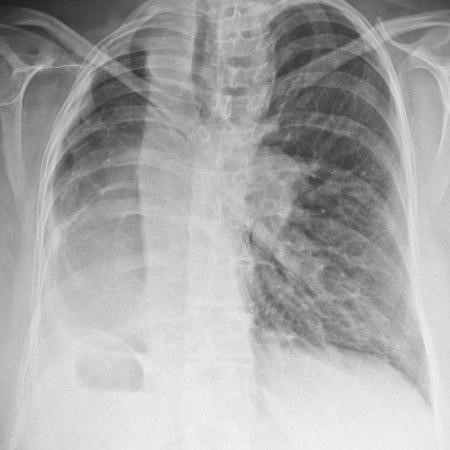

In [9]:
hf[0]["image"]

In [10]:
hf[0]["text"]

'Consolidation seen as a confluent area of increased attenuation in the right upper lobe. Findings are compatible with Lobar pneumonia. The air bronchogram sign is clearly visible within this region, indicating patent airways despite the surrounding alveolar filling. There is no evidence of significant pleural effusion or mediastinal shift. Clinical correlation with fever and cough would be beneficial.'

In [11]:
hf[0]["__class__"]

'Chest_Changes'

#### Main: โหลด dataset จาก local

In [3]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

print(hf)
print(hf.features)

Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 6085
})
{'image': Image(mode=None, decode=True), 'text': Value('string'), '__class__': Value('string')}


- ส่ง train_hf ให้เป็น train_dataset และ val_hf ให้เป็น eval_dataset ระหว่างฝึก
- ตอนจบเรียก trainer.evaluate(eval_dataset=test_hf) เพื่อรายงานผล บน test set

In [4]:
# แบ่ง train/test (30%) ก่อน
splits = hf.train_test_split(test_size=0.3, seed=42, shuffle=True)
train_hf = splits["train"]
tmp_hf   = splits["test"]

# แบ่ง tmp ให้เป็น val/test อย่างละครึ่ง → ได้ 15/15
vt = tmp_hf.train_test_split(test_size=0.5, seed=42, shuffle=True)
val_hf  = vt["train"]
test_hf = vt["test"]

print(train_hf)
print(val_hf)
print(test_hf)

Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 4259
})
Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 913
})
Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 913
})


### 5. แปลง Dataset เป็น Conversation Format

- แปลงข้อมูลให้เป็นรูปแบบ Chat (user → assistant)
- user → ส่งภาพ + คำสั่ง
- assistant → ตอบกลับด้วยข้อความ

#### Test: (ภาพสมการ LaTeX)

In [ ]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        {"role": "user", "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        {"role" : "assistant", "content" : [
            {"type" : "text", "text" : sample["text"]} ]
        },
    ]
    return {"messages" : conversation}

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [16]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

#### Main : dataset ของเราเอง

In [5]:
instruction = "Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."

def convert_to_conversation(sample):
    cls_name = sample["__class__"]
    description = sample["text"]

    answer = f"Class: {cls_name}\nExplanation: {description}"
    
    conversation = [
        {"role": "user", "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        {"role" : "assistant", "content" : [
            {"type" : "text", "text" : answer} ]
        },
    ]
    
    return {"messages" : conversation}

converted_dataset = [convert_to_conversation(sample) for sample in train_hf]

converted_dataset_val = [convert_to_conversation(sample) for sample in val_hf]

converted_dataset_test = [convert_to_conversation(sample) for sample in test_hf]

converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=450x450>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Class: Lower_Density\nExplanation: Collapsed lung / visceral pleural line observed showing visceral pleural line with absent peripheral lung markings on the left side. A small amount of apical collapse is noted. The remaining lung fields are clear. No associated pleural effusion is present. Findings are compatible with Lower density (pneumothorax, pneumomediastinum, pneumoperitoneum).'}]}]}

### 6. ทดสอบโมเดลก่อนฝึก

#### Test: (ภาพสมการ LaTeX)

In [17]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                    use_cache = True, temperature = 1.5, min_p = 0.1)

The given equation in LaTeX is:

\begin{equation}
H'= \beta \mathcal{N} \int \mathrm{d}\lambda\! \bigg{\{}  \frac{1}{2\beta^2\!\lambda^2}\partial_{\zeta}\zeta^* \partial_{\bar{\zeta}} \zeta + V(\lambda) \zeta^* \zeta \bigg{\}}\ .
\end{equation}

This represents a Hamiltonian integral expression where \(H'\) denotes a Hamiltonian, \( \beta \), \( \math


#### Main: 

In [22]:
FastVisionModel.for_inference(model) # Enable for inference!

image = hf[0]["image"]
instruction = "Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                    use_cache = True, temperature = 1.5, min_p = 0.1)

The given chest X-ray demonstrates signs of **Pleural Effusion**. 

The patient shows:
- A fluid-filled left hemithorax with blunting of costophrenic angles, indicative of pleural effusion.
- The right-sided expansion of the chest may indicate asymmetry but this is not definitive and could be secondary to other pathologies such as mediastinal shift or atelectasis in the opposite lung. Further imaging or clinical correlation is needed for an exact diagnosis.

In summary:
- **Chest_Changes**: The presence of a significant pleural effusion requires prompt medical evaluation considering the possibility of underlying pathology


### 7. ฝึกโมเดล (Training)

- ใช้ SFTTrainer ทำการ supervised fine-tuning
- ใช้ข้อมูล converted_dataset ที่มีคู่ (ภาพ → LaTeX)
- กำหนด hyperparameters เช่น batch size, learning rate

ในการแสดง Performance Graph สร้างฟังก์ชันก็บค่า Training Metrics

In [6]:
import re
import numpy as np
from evaluate import load

# โหลด metric BLEU เพียงครั้งเดียว
bleu = load("bleu")

# รายชื่อคลาสที่อนุญาต
ALLOWED_CLASSES = {
    "Chest_Changes",
    "Degenerative_Infectious",
    "Higher_Density",
    "Inflammatory_Pneumonia",
    "Lower_Density",
    "Mediastinal_Changes",
    "Normal",
    "Obstructive",
}

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # ===== ฟังก์ชันย่อยภายในสำหรับดึงชื่อคลาส =====
    def extract_class(text: str):
        """ดึงชื่อคลาสจากข้อความ (ถ้ามี)"""
        if not isinstance(text, str):
            return None
        for cls in ALLOWED_CLASSES:
            # ใช้ regex ค้นชื่อคลาสแบบ exact (ไม่สนข้อความอื่นรอบ ๆ)
            if re.search(rf"\b{re.escape(cls)}\b", text):
                return cls
        return None
    # ===============================================

    # แปลง token IDs เป็นข้อความ
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ดึงชื่อคลาสจาก pred และ label
    pred_classes = [extract_class(p) for p in preds]
    label_classes = [extract_class(l) for l in labels]

    # คำนวณ accuracy — นับถูกถ้าชื่อคลาสตรงกัน
    correct, total = 0, 0
    for p_cls, l_cls in zip(pred_classes, label_classes):
        if l_cls is not None:
            total += 1
            if p_cls == l_cls:
                correct += 1
    acc = correct / total if total > 0 else 0.0

    # คำนวณ BLEU score (ความใกล้เคียงข้อความ)
    bleu_score = bleu.compute(
        predictions=[[p.split()] for p in preds],
        references=[[[l.split()]] for l in labels]
    )["bleu"]

    # คืนค่า metric ทั้งคู่
    return {
        "eval_accuracy": acc,
        "eval_bleu": bleu_score,
    }

แล้วเพิ่มใน SFTTrainer

In [7]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

# เร่งคณิตศาสตร์บน GPU (Ampere+)
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)  # enable training

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== Training schedule =====
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 10,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 2e-4,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        max_grad_norm = 1.0,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer.predict_with_generate = True
trainer.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

Unsloth: Model does not have a default image size - using 512


In [8]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
2.488 GB of memory reserved.


In [9]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,259 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,0.560600,2.139121
20,0.304200,1.177546
30,0.235800,1.019091


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [10]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1295.4972 seconds used for training.
21.59 minutes used for training.
Peak reserved memory = 5.941 GB.
Peak reserved memory for training = 3.453 GB.
Peak reserved memory % of max memory = 99.066 %.
Peak reserved memory for training % of max memory = 57.579 %.


#### สร้างกราฟ Accuracy / Loss จาก trainer.state.log_history

บางเวอร์ชันของ TRL/Unsloth + VLM (เช่น Qwen2.5-VL) ถ้าเปิด prediction_loss_only=False แล้ว Trainer จะพยายาม “รวบรวม/แพด” ผลทำนายระหว่าง eval → ชนกับวัตถุที่ไม่ใช่ tensor (เช่น EmptyLogits) แล้วพังทันที => ทำให้ไม่มี Accuracy มาโชว์

In [11]:
print("Final metrics:", trainer_stats.metrics)
print("Final eval accuracy:", trainer_stats.metrics.get("eval_accuracy", None))
print("Final eval loss:", trainer_stats.metrics.get("eval_loss", None))

Final metrics: {'train_runtime': 1295.4972, 'train_samples_per_second': 0.185, 'train_steps_per_second': 0.023, 'total_flos': 2174814776696832.0, 'train_loss': 0.4907341495156288, 'epoch': 0.056338028169014086}
Final eval accuracy: None
Final eval loss: None


In [12]:
# ดูค่ารวม
print("Training loss:", trainer_stats.training_loss)
print("All metrics:", trainer_stats.metrics)

# แปลง log เป็น DataFrame
import pandas as pd
df = pd.DataFrame(trainer.state.log_history)

# ดูคอลัมน์ที่มี
print(df.columns)
display(df)

Training loss: 0.4907341495156288
All metrics: {'train_runtime': 1295.4972, 'train_samples_per_second': 0.185, 'train_steps_per_second': 0.023, 'total_flos': 2174814776696832.0, 'train_loss': 0.4907341495156288, 'epoch': 0.056338028169014086}
Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second',
       'train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss'],
      dtype='object')


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9274,1.654138,0.000000,0.001878,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.9366,1.725886,0.000040,0.003756,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.9023,1.621622,0.000080,0.005634,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.9239,1.556414,0.000120,0.007512,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8227,1.224167,0.000160,0.009390,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.7902,1.245444,0.000200,0.011268,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.7037,1.105654,0.000192,0.013146,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.6341,1.091617,0.000184,0.015023,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.5896,1.108674,0.000176,0.016901,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.5606,0.999770,0.000168,0.018779,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


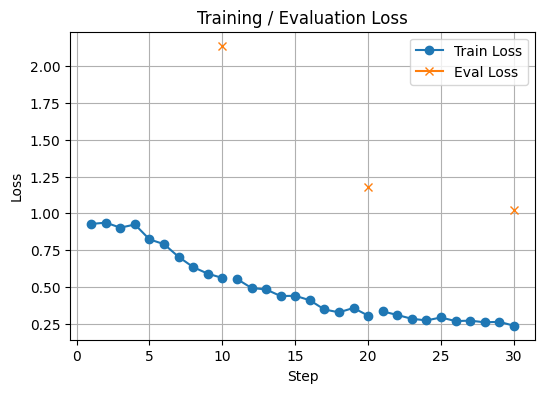

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Test 1

- ใช้ trainer.predict(...) กับ blind/val dataset แล้วคำนวณ metric เอง

In [ ]:
from transformers.generation import GenerationConfig
gc = GenerationConfig.from_model_config(trainer.model.config)
gc.return_dict_in_generate = False
gc.output_scores = False
trainer.model.generation_config = gc

In [18]:
import re, numpy as np
from evaluate import load

# ----- ตั้งค่า/คงไว้ -----
ALLOWED_CLASSES = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}
bleu_metric = load("bleu")

def extract_class(text: str):
    """ดึงชื่อคลาสแบบไม่สนพิมพ์เล็ก-ใหญ่ หากพบคืนชื่อมาตรฐาน ตาม ALLOWED_CLASSES"""
    if not isinstance(text, str):
        return None
    for cls in ALLOWED_CLASSES:
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

# ===== 1) รัน predict บน blind/val =====
pred_out = trainer.predict(converted_dataset_test)   # ไม่มี labels ก็รันได้

In [19]:
# Debug
print("pred_out type:", type(pred_out))
print("pred_out.predictions:", type(pred_out.predictions))
print("Example:", pred_out.predictions[:1] if pred_out.predictions is not None else "None!")

# Debug structure ดูก่อน
print("Type of pred_out.predictions:", type(pred_out.predictions))
print("Keys or shape:", getattr(pred_out.predictions, "keys", lambda: None)())

# ✅ กรณีเป็น dict
if isinstance(pred_out.predictions, dict) and "sequences" in pred_out.predictions:
    pred_ids = pred_out.predictions["sequences"]
# ✅ กรณีเป็น tuple/list
elif isinstance(pred_out.predictions, (list, tuple)) and len(pred_out.predictions) > 0:
    pred_ids = pred_out.predictions[0]
else:
    pred_ids = pred_out.predictions  # ปกติ (array/tensor)

# ===== 2) decode prediction เป็นข้อความ =====
# pred_ids = pred_out.predictions                    # (num_samples, seq_len)
pred_texts = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

# ===== 3) (ถ้ามี labels) คำนวณ Accuracy + BLEU =====
metrics = {}
has_labels = False

# กรณี datasets แบบ HF: มักมี .features (ถ้าไม่มีก็ลอง hasattr/try-except)
try:
    has_labels = "labels" in getattr(converted_dataset_test, "features", {})
except Exception:
    has_labels = False

label_texts = []

if has_labels:
    # วิธีปลอดภัย: วนอ่าน labels จาก dataset ตรง ๆ
    # (เพราะ pred_out.label_ids อาจไม่มี/shape ไม่ชัดในบางเวอร์ชัน)
    for i in range(len(converted_dataset_test)):
        ex = converted_dataset_test[i]
        # label อาจอยู่ใน ex["labels"] เป็น list[int]
        lbl_ids = ex.get("labels", None)
        if lbl_ids is None:
            label_texts.append("")  # ไม่พบ label ในตัวอย่างนี้
            continue
        lbl_ids = np.array(lbl_ids, dtype=np.int64)
        # แทน -100 ด้วย pad_token_id ก่อน decode
        pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id
        lbl_ids = np.where(lbl_ids == -100, pad_id, lbl_ids)
        label_texts.append(tokenizer.decode(lbl_ids, skip_special_tokens=True))

    # ให้ความยาวตรงกันกับ pred_texts
    if len(label_texts) > len(pred_texts):
        label_texts = label_texts[:len(pred_texts)]
    elif len(pred_texts) > len(label_texts):
        pred_texts = pred_texts[:len(label_texts)]

    # === Accuracy แบบ class-insensitive (ตรงกับนิยามของคุณ) ===
    pred_classes = [extract_class(p) for p in pred_texts]
    label_classes = [extract_class(l) or l.strip() for l in label_texts]

    correct = 0
    total = 0
    for p_cls, l_cls in zip(pred_classes, label_classes):
        if l_cls in ALLOWED_CLASSES:
            total += 1
            if p_cls == l_cls:
                correct += 1
    acc = (correct / total) if total > 0 else 0.0
    metrics["eval_accuracy"] = acc

    # === BLEU เพื่อวัดความใกล้เคียงข้อความโดยรวม ===
    try:
        metrics["eval_bleu"] = bleu_metric.compute(
            predictions=[[p.strip().split()] for p in pred_texts],
            references=[[[l.strip().split()]] for l in label_texts],
        )["bleu"]
    except Exception:
        metrics["eval_bleu"] = float("nan")

# ===== 4) log metric เข้า TensorBoard/W&B และแสดงผล =====
if metrics:
    trainer.log(metrics)  # จะขึ้นกราฟถ้าตั้ง report_to=["tensorboard"] หรือ ["wandb"]
print("Manual eval:", metrics)  # ex: {'eval_accuracy': 0.84, 'eval_bleu': 0.41}

# (ถ้าเป็น blind ไม่มี labels: บันทึกผลทำนายส่งตรวจภายหลัง)
if not has_labels:
    import pandas as pd
    # ถ้า dataset มีฟิลด์ 'id' ก็ใช้, ไม่มีก็สร้าง running index
    ids = []
    for i in range(len(converted_dataset_test)):
        ex = converted_dataset_test[i]
        ids.append(ex.get("id", i))
    df_submit = pd.DataFrame({"id": ids[:len(pred_texts)], "prediction": pred_texts})
    df_submit.to_csv("submission_blind.csv", index=False, encoding="utf-8-sig")
    print("Saved predictions -> submission_blind.csv")


pred_out type: <class 'transformers.trainer_utils.PredictionOutput'>
pred_out.predictions: <class 'NoneType'>
Example: None!
Type of pred_out.predictions: <class 'NoneType'>
Keys or shape: None


TypeError: 'NoneType' object is not iterable

### 8. ทดสอบโมเดลหลังฝึก

รัน inference อีกครั้งเพื่อเปรียบเทียบ performance หลัง fine-tuning

In [15]:
FastVisionModel.for_inference(model) # Enable for inference!

image = hf[0]["image"]
instruction = "Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                    use_cache = True, temperature = 1.5, min_p = 0.1)

Class: Mediastinal_Changes
Explanation: The chest X-ray shows increased transparency adjacent to both right and left cardiophrenic angles with variable clarity indicating partial atelectasis or pneumonia. This imaging feature suggests inflammatory change that is consistent with an underlying infectious etiology in this setting. The clinical scenario strongly supports infection leading to lung parenchymal changes. There are no visible effusions, mass lesions, or linear changes typical for entities like neoplasms or autoimmune conditions. The features are compatible with Degenerative_Infectious based on clinical and radiographic correlation, particularly considering the known clinical presentations associated with specific conditions in similar


### 9. บันทึกโมเดล

- บันทึกเฉพาะ LoRA adapters ไม่ใช่ full model
- สามารถโหลดกลับมาใช้ใหม่ได้

In [ ]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_20251005_175200


### 10. ทดสอบการทำ Mannul Eval

- ใช้ seed เดิม คือ 42 ในการแบ่ง test data

In [1]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

print(hf)
print(hf.features)

# แบ่ง train/test (30%) ก่อน
splits = hf.train_test_split(test_size=0.3, seed=42, shuffle=True)
train_hf = splits["train"]
tmp_hf   = splits["test"]

# แบ่ง tmp ให้เป็น val/test อย่างละครึ่ง → ได้ 15/15
vt = tmp_hf.train_test_split(test_size=0.5, seed=42, shuffle=True)
val_hf  = vt["train"]
test_hf = vt["test"]

print(test_hf)

c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 6085
})
{'image': Image(mode=None, decode=True), 'text': Value('string'), '__class__': Value('string')}
Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 913
})


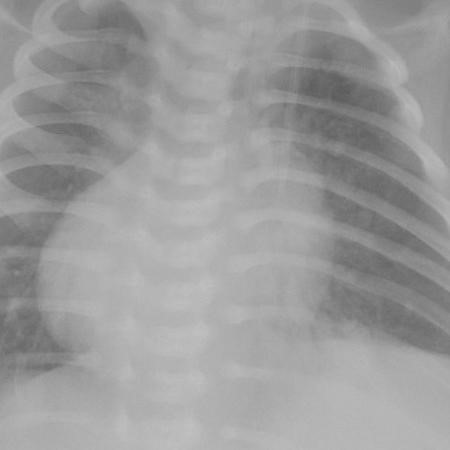

In [2]:
test_hf[0]["image"]

In [5]:
test_hf[0]["__class__"]

'Inflammatory_Pneumonia'

In [3]:
import re, torch
from unsloth import FastVisionModel
from transformers import TextStreamer
from PIL import Image
from tqdm import tqdm
import numpy as np

# =======================
# 1️⃣ โหลดโมเดล base + LoRA
# =======================
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_20251005_175200")  # path ที่คุณ save LoRA ไว้
FastVisionModel.for_inference(model)
model.eval()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1006 16:26:51.663000 11144 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): lora.Linear4bit(
              (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=3840, bi

In [4]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 100 ตัวแรก =====
subset = test_hf.select(range(100))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน CLASS_SET)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 100 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_pg3.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Inflammatory_Pneumonia, pred_class : Mediastinal_Changes
id: 1, true_class : Chest_Changes, pred_class : Inflammatory_Pneumonia
id: 2, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 3, true_class : Inflammatory_Pneumonia, pred_class : Degenerative_Infectious
id: 4, true_class : Obstructive, pred_class : Mediastinal_Changes
id: 5, true_class : Normal, pred_class : Mediastinal_Changes
id: 6, true_class : Normal, pred_class : Mediastinal_Changes
id: 7, true_class : Obstructive, pred_class : Mediastinal_Changes
id: 8, true_class : Higher_Density, pred_class : Mediastinal_Changes
id: 9, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 10, true_class : Normal, pred_class : Mediastinal_Changes
id: 11, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 12, true_class : Higher_Density, pred_class : Mediastinal_Changes
id: 13, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 14,

### 11. Grad-CAM on Transformers

In [1]:
import re, torch
from unsloth import FastVisionModel
from transformers import TextStreamer
from PIL import Image
from tqdm import tqdm
import numpy as np

# =======================
# โหลดโมเดล base + LoRA
# =======================

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_20251005_175200")  # path ที่คุณ save LoRA ไว้

c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1006 17:06:01.245000 4460 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [27]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

# แบ่ง train/test (30%) ก่อน
splits = hf.train_test_split(test_size=0.3, seed=42, shuffle=True)
train_hf = splits["train"]
tmp_hf   = splits["test"]

# แบ่ง tmp ให้เป็น val/test อย่างละครึ่ง → ได้ 15/15
vt = tmp_hf.train_test_split(test_size=0.5, seed=42, shuffle=True)
val_hf  = vt["train"]
test_hf = vt["test"]

อ้างอิงจากข้อ 10 การทำ Mannul Eval บน test_hf ที่ seed=42 (ภาพเดียวกัน ค่าเดียวกัน)

- id: 0, true_class : Inflammatory_Pneumonia, pred_class : Mediastinal_Changes => ทายผิด
- id: 18, true_class : Mediastinal_Changes, pred_class : Mediastinal_Changes => ทายถูก

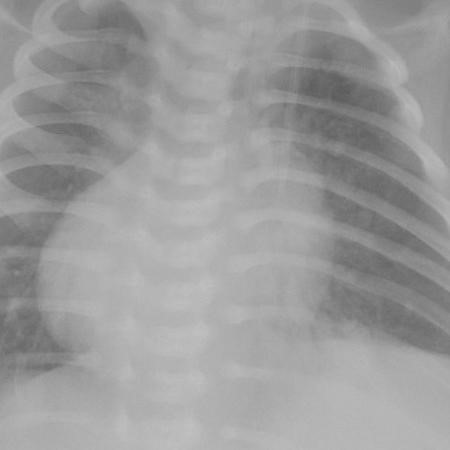

In [28]:
test_hf[0]["image"]

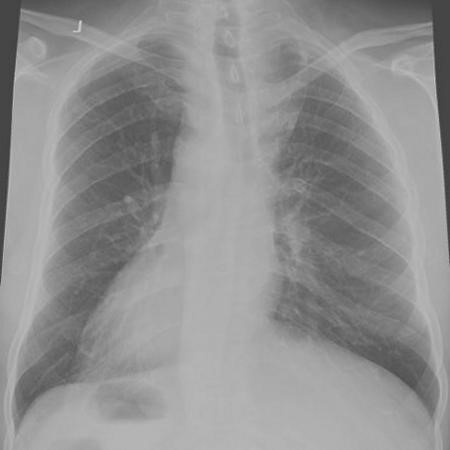

In [29]:
test_hf[18]["image"]

In [32]:
image = hf[18]["image"]

In [19]:
import torch, math
from PIL import Image
from transformers import TextStreamer

model.eval()

# ---------- เตรียมข้อมูลเหมือนเดิม ----------

instruction = (
    "Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, "
    "Lower_Density, Mediastinal_Changes, Normal, or Obstructive."
)
messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": instruction},
    ],
}]
prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

enc = tokenizer(
    image,
    prompt,
    add_special_tokens=False,
    return_tensors="pt",
).to(model.device)

# ---- ฟังก์ชันบังคับ dtype + device ให้ตรงกับโมเดล ----
def cast_to_model_dtype_and_device(batch, model):
    out = {}
    for k, v in batch.items():
        if torch.is_tensor(v):
            # long/bool ไม่ต้องแคสต์ dtype
            if torch.is_floating_point(v):
                v = v.to(device=model.device, dtype=model.dtype)
            else:
                v = v.to(device=model.device)
            out[k] = v
        else:
            out[k] = v
    return out

enc = cast_to_model_dtype_and_device(enc, model)

# ---------- รอบแรก: generate เพื่อเอา target token ----------
with torch.no_grad(), torch.autocast(device_type="cuda", dtype=model.dtype):
    gen = model.generate(
        **enc,
        max_new_tokens=64,
        temperature=1.0,
        min_p=0.1,
        use_cache=True,
        return_dict_in_generate=True,
    )
generated_ids = gen.sequences  # shape: [B, L_full]

# ---------- เตรียม teacher forcing (CAUSAL LM ใช้ input_ids) ----------
# ให้โมเดลเห็น "ทุกตัวก่อนหน้า" แล้วพยากรณ์ตัวถัดไป
tf_input_ids  = generated_ids[:, :-1].to(model.device)  # context ถึงตัวก่อนหน้า
target_ids    = generated_ids[:,  1:].to(model.device)  # คำตอบจริงที่ต้องการให้ทายได้

# ดึง "vision inputs" เดิมกลับมา (แต่เปลี่ยน input_ids เป็น tf_input_ids)
vision_inputs = {k: v for k, v in enc.items() if k not in ("input_ids", "attention_mask")}

# ---------- เลือกเลเยอร์ที่จะ hook (วิชั่นบล็อก/ครอส-attn) ----------
def find_last_visual_block(m):
    target_name, target_mod = None, None
    for name, mod in m.named_modules():
        n = name.lower()
        if (("vision" in n or "visual" in n or "vit" in n or "clip" in n or "image" in n) and
            ("block" in n or ".blocks." in n or "layer" in n or "encoder" in n)):
            if hasattr(mod, "forward"):
                target_name, target_mod = name, mod
    return target_name, target_mod

vision_name, vision_block = find_last_visual_block(model)
assert vision_block is not None, "หา vision block ไม่เจอ—พิมพ์ list(model.named_modules()) เพื่อตรวจชื่อโมดูล"
print("Hook target:", vision_name, "->", type(vision_block))

# ---------- hook เก็บ activation + gradient ----------
acts = {}
def _pick_tensor_from_output(out):
    import torch
    from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
    if isinstance(out, torch.Tensor):
        return out
    if isinstance(out, (tuple, list)):
        for x in out:
            if isinstance(x, torch.Tensor):
                return x
    if isinstance(out, dict):
        for k in ("last_hidden_state", "hidden_states", "attentions"):
            if k in out:
                x = out[k]
                if isinstance(x, torch.Tensor):
                    return x
                if isinstance(x, (tuple, list)) and len(x) > 0 and isinstance(x[0], torch.Tensor):
                    return x[0]
    if isinstance(out, (BaseModelOutput, BaseModelOutputWithPooling)):
        if isinstance(out.last_hidden_state, torch.Tensor):
            return out.last_hidden_state
        if out.hidden_states and isinstance(out.hidden_states[-1], torch.Tensor):
            return out.hidden_states[-1]
    raise TypeError(f"Cannot pick tensor from output type: {type(out)}")

def fwd_hook(module, inp, out):
    tensor_out = _pick_tensor_from_output(out)
    acts["feat"] = tensor_out
    if not tensor_out.requires_grad:
        tensor_out.requires_grad_(True)
    tensor_out.retain_grad()

hook_handle = vision_block.register_forward_hook(fwd_hook)

# ---------- forward แบบมีกราเดียนต์ ----------
with torch.autocast(device_type="cuda", dtype=model.dtype):
    outputs = model(
        **vision_inputs,
        input_ids=tf_input_ids,          # << ใช้ input_ids แทน decoder_input_ids
        use_cache=False,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    )
    
# ---------- จัดความยาวให้ตรงกันก่อน index ----------
T_logits  = outputs.logits.size(1)      # ความยาวเวลาใน logits
T_targets = target_ids.size(1)
T = min(T_logits, T_targets)
if T < 1:
    raise RuntimeError(f"Empty sequence: T_logits={T_logits}, T_targets={T_targets}")

# โฟกัสที่ตำแหน่งสุดท้ายที่ “ทั้งสองฝ่าย” มีอยู่จริง
b = 0
t = T - 1
target_token_id = target_ids[b, t]

# ---------- backward ----------
model.zero_grad(set_to_none=True)
logit = outputs.logits[b, t, target_token_id]
logit.backward()

hook_handle.remove()

# ---------- Grad-CAM (ทนรูปทรง) ----------
feat = acts["feat"]
grad = acts["feat"].grad

# 0) ความปลอดภัย: ใช้ FP32 ตอนคำนวณ
feat = feat.float()
grad = grad.float()

# 1) ทำให้เป็น 3D เสมอ: (B, N, C)
def to_bnc(x):
    if x.dim() == 3:             # (B, N, C) -> ok
        return x
    if x.dim() == 2:             # (N, C) -> ใส่ B=1
        return x.unsqueeze(0)
    if x.dim() == 4:
        # กรณี (B, H, W, C) หรือ (B, C, H, W)
        B, A, D, E = x.shape
        # เดาว่า (B, H, W, C) หาก "ช่องคุณลักษณะ" อยู่ท้าย (ส่วนใหญ่ของวิชั่นบล็อก HF)
        # ถ้าเป็น (B, C, H, W) ให้สลับแกน
        if A * D == E:  # heuristic เล็กน้อย: ไม่ค่อยเกิด กันท่าไว้
            pass
        # เช็คว่าช่องหลังสุดคือ C (คุณลักษณะ)
        if x.shape[-1] < max(x.shape[1], x.shape[2]):  # แปลว่าอาจเป็น (B, C, H, W)
            # -> สลับเป็น (B, H, W, C)
            x = x.permute(0, 2, 3, 1).contiguous()
        B, H, W, C = x.shape
        return x.view(B, H * W, C)
    raise RuntimeError(f"Unsupported feat shape: {x.shape}")

feat = to_bnc(feat)
grad = to_bnc(grad)

# 2) จัดการ token พิเศษ: ทำให้ N เป็นกำลังสอง (สำหรับสร้างกริด)
B, N, C = feat.shape
def maybe_strip_special_tokens(feat, grad):
    B, N, C = feat.shape
    import math
    def is_square(k): 
        r = int(math.sqrt(k))
        return r * r == k, r
    ok, side = is_square(N)
    if ok:
        return feat, grad, side
    # ลองตัด 1 token แรก (เช่น CLS)
    ok1, side1 = is_square(N - 1)
    if ok1:
        return feat[:, 1:, :], grad[:, 1:, :], side1
    # ลองตัด 2 token แรก (กันพลาดบางสถาปัตยกรรม)
    ok2, side2 = is_square(N - 2)
    if ok2:
        return feat[:, 2:, :], grad[:, 2:, :], side2
    # ลองตัดท้าย 1 ตัว (เผื่อมี SEP พิเศษ)
    ok3, side3 = is_square(N - 1)
    if ok3:
        return feat[:, :-1, :], grad[:, :-1, :], side3
    raise AssertionError(
        f"N={N} ไม่เป็นกำลังสอง และเดา token พิเศษไม่สำเร็จ — "
        "ลองพิมพ์ shape ของ acts['feat'] ก่อน hook/หลัง hook เพื่อตรวจชื่อเลเยอร์ที่เลือก"
    )

feat, grad, side = maybe_strip_special_tokens(feat, grad)

# 3) น้ำหนักแบบ Grad-CAM: เฉลี่ยกราเดียนต์บนเชิงพื้นที่
# เดิม: weights = grad.mean(dim=1, keepdim=True)  # (B, 1, C)
# แก้ให้บีบเป็น (B, C) เพื่อหลีกเลี่ยง '1' ในสมการ einsum
weights = grad.mean(dim=1)  # (B, C)

# 4) รวมเชิงเส้นตามช่องคุณลักษณะ (เลือกวิธีใดวิธีหนึ่ง)

# วิธี A: ใช้ einsum ที่ถูกต้อง (ไม่มีช่องว่าง/ตัวเลขในซับสคริปต์)
cam = torch.einsum('bnc,bc->bn', feat, weights)  # (B, N)

# --- หรือ ---

# วิธี B: เขียนตรง ๆ แบบ elementwise (อ่านง่าย ไม่พึ่ง einsum)
# cam = (feat * weights.unsqueeze(1)).sum(dim=2)  # (B, N)

cam = torch.relu(cam)

# 5) ทำเป็นกริด + นอร์มัลไลซ์
B, N, C = feat.shape  # อัปเดต B,N เผื่อมีการตัด token พิเศษไปก่อนหน้า
cam_2d = cam.view(B, side, side)
cam_2d = cam_2d - cam_2d.min()
cam_2d = cam_2d / (cam_2d.max() + 1e-6)

# 6) รีไซส์กลับสัดส่วนภาพจริง
import torch.nn.functional as F
H_img, W_img = image.size[1], image.size[0]
cam_resized = F.interpolate(
    cam_2d.unsqueeze(1), size=(H_img, W_img),
    mode="bilinear", align_corners=False
).squeeze(1)

heatmap = cam_resized[0].detach().cpu().numpy()

Hook target: model.visual.blocks.31.mlp.act_fn -> <class 'torch.nn.modules.activation.SiLU'>


In [21]:
print(type(heatmap))
print(heatmap)

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 🥬 กรณีที่โมเดลทำนายผิด

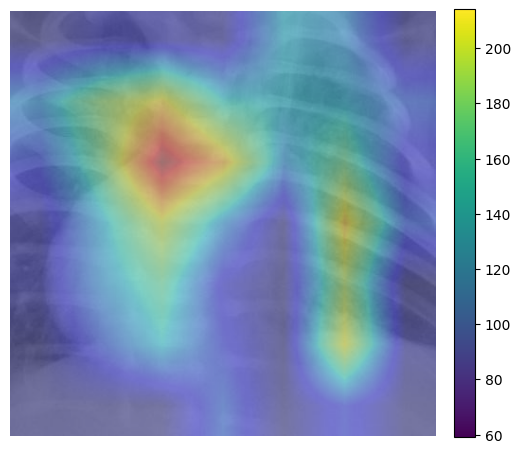

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) เตรียมภาพและ heatmap ให้อยู่ในสเกล 0..1 และไร้ NaN
img_rgb = image.convert("RGB")
hm = np.nan_to_num(heatmap.astype(np.float32))
hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)

# 2) วาดภาพ + ซ้อน heatmap
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)                         # ชั้นภาพจริง
plt.imshow(hm, cmap="jet", alpha=0.45)      # ชั้น heatmap (โปร่งใส)
plt.axis("off")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.contour(hm, levels=[0.6, 0.8], linewidths=1.2, colors="white")
plt.savefig("overlay_matplotlib_f.png", dpi=300, bbox_inches="tight")
plt.show()

#### 🥬 กรณีที่โมเดลทำนายถูก

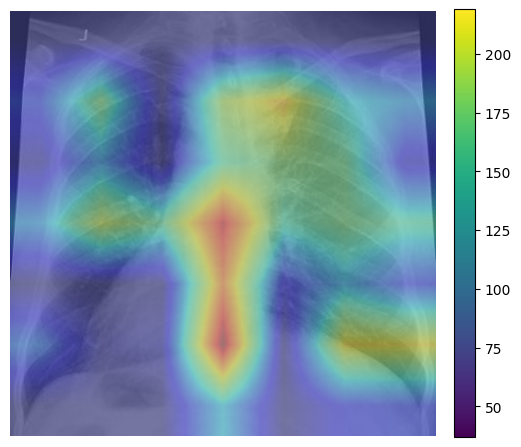

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) เตรียมภาพและ heatmap ให้อยู่ในสเกล 0..1 และไร้ NaN
img_rgb = image.convert("RGB")
hm = np.nan_to_num(heatmap.astype(np.float32))
hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)

# 2) วาดภาพ + ซ้อน heatmap
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)                         # ชั้นภาพจริง
plt.imshow(hm, cmap="jet", alpha=0.45)      # ชั้น heatmap (โปร่งใส)
plt.axis("off")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.contour(hm, levels=[0.6, 0.8], linewidths=1.2, colors="white")
plt.savefig("overlay_matplotlib_t.png", dpi=300, bbox_inches="tight")
plt.show()